<a href="https://colab.research.google.com/github/BabarMuaz/skinDiseaseDetection/blob/main/vgg16_dataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# copy data to colab dir
!cp -rf /content/drive/MyDrive/Splitted_SuperCleanedDataset_70_20_10 /content

# to remove this folder
#%rm -rf Splitted_SuperCleanedDataset_70_20_10 

In [3]:
# imporitng required libraries

#general
import itertools
import numpy as np # it is confusion matrix and classification function dependency 
import matplotlib.pyplot as plt #  it is training plots func dependency

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # to save model and early stopping
from tensorflow.keras.metrics import categorical_crossentropy # loss function
from tensorflow.keras import layers # used when model is build Sequentially
from tensorflow.keras.preprocessing.image import ImageDataGenerator # data processing function
from tensorflow.keras.optimizers import Adam # optimizer
# sklearn
from sklearn.metrics import classification_report,confusion_matrix # to generate confusion matrix and classification summary

In [4]:
# get paths to fetch data
train_path = "/content/Splitted_SuperCleanedDataset_70_20_10/train"
valid_path = "/content/Splitted_SuperCleanedDataset_70_20_10/val"
test_path = "/content/Splitted_SuperCleanedDataset_70_20_10/test"

In [5]:
# Create Data Batches for training

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
                                         directory=train_path, 
                                         target_size=(224,224),  
                                         batch_size=3904,
                                         classes=['melanoma', 'nevus'], 
                                         class_mode='categorical',
                                         shuffle=True)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
                                         directory=valid_path, target_size=(224,224),
                                         batch_size=1088,
                                         classes=['melanoma', 'nevus'], 
                                         class_mode='categorical',
                                         shuffle=True)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
                                         directory=test_path, 
                                         target_size=(224,224), 
                                         batch_size=564,
                                         classes=['melanoma', 'nevus'], 
                                         class_mode='categorical',
                                         shuffle=True)

Found 3904 images belonging to 2 classes.
Found 1088 images belonging to 2 classes.
Found 564 images belonging to 2 classes.


In [6]:
# checking how classes are labelled, somestimes depending on the server folders are stored alphabatelly or not
print("training data labelled as = ",train_batches.class_indices)
print("validation data labelled as = ",valid_batches.class_indices)
print("testing data labelled as = ",test_batches.class_indices)

training data labelled as =  {'melanoma': 0, 'nevus': 1}
validation data labelled as =  {'melanoma': 0, 'nevus': 1}
testing data labelled as =  {'melanoma': 0, 'nevus': 1}


In [7]:
(x_train, y_train) = next(train_batches)  # creating one batch for training images, purpose is to put data on ram faster execution

In [8]:
(x_test, y_test) = next(valid_batches)  # creating one batch for validation images, purpose is to put data on ram faster execution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

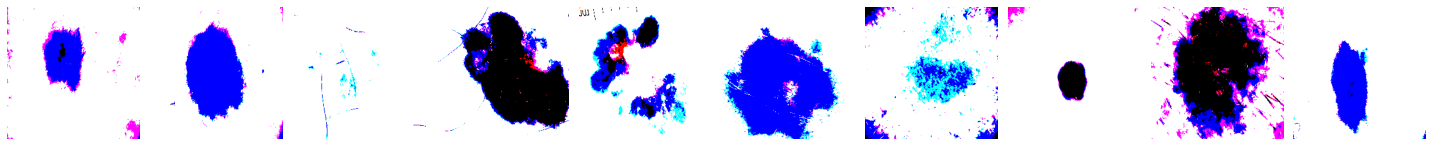

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [9]:
# function to see images in Datagen, this is used to see images after preprocessing step
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(x_train)
print(y_train)

In [10]:
# above ImageDataGenerator function along with next is used to put data on ram
# when data is on ram training is very quick, CAUTION: only do this if your dataset can fit on ram
# if dataaugmentation, than apply here
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)  # data in batches is fed to model using this 


In [11]:
# Create a base Densenet model
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = False
base_model.summary()

58900480/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [12]:
# custom classifier is build on top of base model
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.1),
                                 tf.keras.layers.Dense(2, activation="softmax")                                     
                                ])

In [13]:
# model compiling and optimizer selection
base_learning_rate = 0.002
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


#create callback
filepath = 'best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [14]:
# train model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=x_train.shape[0]//32,
                    epochs = 50 , 
                    validation_data = (x_test, y_test),
                    callbacks=callbacks)

Epoch 1/50
122/122 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.7825
Epoch 1: val_loss improved from inf to 0.45686, saving model to best_model.hdf5
122/122 [==============================] - 23s 108ms/step - loss: 0.6026 - accuracy: 0.7825 - val_loss: 0.4569 - val_accuracy: 0.8033
Epoch 2/50
122/122 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8263
Epoch 2: val_loss improved from 0.45686 to 0.36615, saving model to best_model.hdf5
122/122 [==============================] - 12s 102ms/step - loss: 0.4134 - accuracy: 0.8263 - val_loss: 0.3661 - val_accuracy: 0.8520
Epoch 3/50
122/122 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.8368
Epoch 3: val_loss improved from 0.36615 to 0.34739, saving model to best_model.hdf5
122/122 [==============================] - 12s 102ms/step - loss: 0.3886 - accuracy: 0.8368 - val_loss: 0.3474 - val_accuracy: 0.8511
Epoch 4/50
122/122 [==============================] - ETA: 0s 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


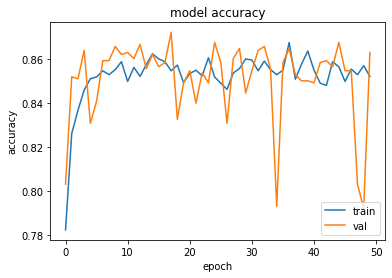

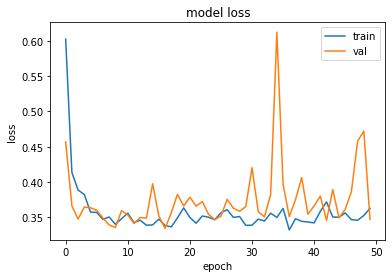

In [15]:
# Plot Training accuracy and loss grpahs

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [16]:
# load the best saved model 
model = tf.keras.models.load_model('best_model.hdf5')

In [17]:
# get testing data
(img, label) = next(test_batches)  # creating one batch for testing images, purpose is to put data on ram faster execution

In [18]:
# print classification sumamry
predict_x=model.predict(img) 
predictions=np.argmax(predict_x,axis=1)
predictions = predictions.reshape(1,-1)[0]
label=np.argmax(label,axis=1)
label = label.reshape(1,-1)[0]
print(classification_report(label, predictions, target_names = ['melanoma','nevus']))

              precision    recall  f1-score   support

    melanoma       0.83      0.86      0.85       282
       nevus       0.86      0.83      0.84       282

    accuracy                           0.84       564
   macro avg       0.84      0.84      0.84       564
weighted avg       0.84      0.84      0.84       564



In [19]:
# This function is used to create Confusion Matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[243  39]
 [ 49 233]]


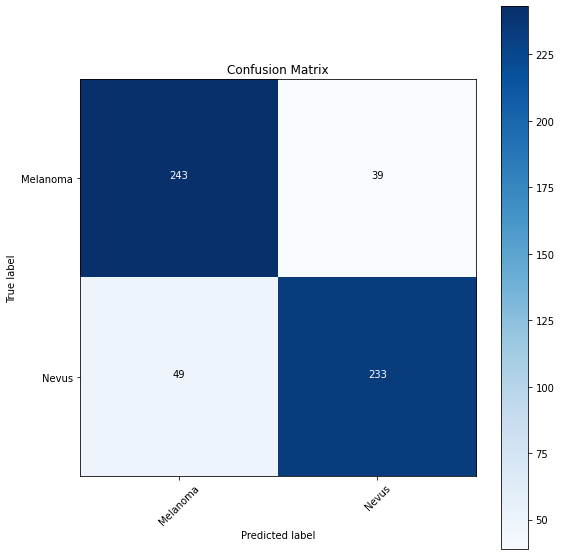

In [20]:
# calling confsion matrix function

cm_aug = confusion_matrix(label, predictions)
plot_confusion_matrix(cm_aug, classes = ['Melanoma','Nevus'], title='Confusion Matrix', normalize=False)